# Exploratory analysis of gene regulatory networks inferred from COVID-19 patients

This notebook contains the exploratory analysis pipeline of gene regulatory networks (GRNs) computed on scRNA-seq data of COVID-19 patients ([Liao *et al.*, 2020](https://www.nature.com/articles/s41591-020-0901-9)). The data is available on GEO ([GSE145926](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE145926)) and contains 10xGenomics pipeline samples from the lung immune microenvironment in the bronchoalveolar lavage fluid (BALF) from <span style="color:red">6 severe</span> and <span style="color:#8B8000">3 moderate</span> COVID-19 patients and <span style="color:green">3 healthy</span> controls (look below).

| Patient ID   | C51 | C52 | C100 | C141 | C142 | C144 | C143 | C145 | C146 | C148 | C149 | C152 |
|--------------|-----|-----|------|------|------|------|------|------|------|------|------|------|
| Patient type | <span style="color:green">C</span>   | <span style="color:green">C</span>   | <span style="color:green">C</span>    | <span style="color:#8B8000">M</span>    | <span style="color:#8B8000">M</span>    | <span style="color:#8B8000">M</span>    | <span style="color:red">S</span>    | <span style="color:red">S</span>    | <span style="color:red">S</span>    | <span style="color:red">S</span>    | <span style="color:red">S</span>    | <span style="color:red">S</span>    |

The raw patient scRNA-seq data should be firstly processed by `scGRN/single_cell_processing/sc_pipeline` module that will apply [`Seurat`](https://satijalab.org/seurat/index.html) pipeline and merge datasets depending on the available cell types. Then, the processed data can be used for GRN inference implemented in `scGRN/network_inference` pipeline.

In this notebook we will only use inferred [`GRNBoost2`](https://arboreto.readthedocs.io/en/latest/algorithms.html) networks. All networks should be pre-processed (i.e. quantile filtered) and saved to `.pickle` (i.e. graph adjacency lists) and `gpickle` (i.e. graph [`NetworkX`](https://networkx.org) objects) formats in the corresponding data folders.

There are 3 types of networks we are working with:
- gene-gene networks (`net_type = 'all'`) - GRNs that contain **all** measured pairwise associations between **genes**
- TF-target networks (`net_type = 'TF'`) - GRNs that contain **only** measured associations between **TFs and their targets**
- enriched TF-target networks (`net_type = 'ctx'`) - GRNs that contain **only** measured and **motif-enriched** associations between **TFs and their targets**

Mainly we will show different visualization methods that will allow us to get some information about the obtained graph networks. Because we are working with huge amounts of data, the same visualization methods could be applied to each network - we will leverage the [`ipywidgets`](https://ipywidgets.readthedocs.io/en/stable/) package that allows the user to interact with the notebook and, in our case, choose the input data set and manipulate the visualization of corresponding figures. 

Because of memory issues, we will only load 3 patient GRNs to RAM: <span style="color:green">C51</span>, <span style="color:#8B8000">C141</span>, and <span style="color:red">C148</span>. The rest of the patients will be loaded "on the fly" when displaying a certain plot. Due to the same problem, we limit the loaded cell types to only T cells, Macrophages, NK cells and Monocytes. We will **not** load the aggregated data sets (e.g. all T cells from all patients).

## Layout of the notebook

- Load packages, set up the namespace for the analysis, configurate path names and other variables
- Load [`NDEx`](https://www.ndexbio.org/#/) networks that will be used for comparison with our networks
- Load 3 patient GRNs to RAM (look above), report the availability of others
- Exploratory data analysis
    - Visualization of general information about gene regulatory networks (node/edge count, distribution of edge (or link) importances)
    - Visualization of general trends across many GRNs (graph properties, patient type-specific differences)
    - Visualization of inferred GRNs as graphs (top links, top targets, etc)
    
## Contacts

For any problems/questions, please contact `mkriukov.job@gmail.com`.

# Setting up the environment..

In [1]:
# Generic
import sys  # managing environmental variables
import os  # file system
import warnings  # managing warnings
from glob import glob  # globbing
import multiprocessing  # parallel execution

# Data managing
import ndex2  # database of biological network
import numpy as np  # scientific programming
import pandas as pd  # working with tabular data

# Graphs
import networkx as nx  # working with network data
import igraph as ig  # working with network data
import leidenalg as la  # community detection
from community import community_louvain  # community detection
from venn import venn, pseudovenn, generate_petal_labels, draw_venn, draw_pseudovenn6  # venn diagram visualization

# Visualization
import matplotlib as mpl  # general visualization
import matplotlib.pyplot as plt  # general visualization
import seaborn as sns  # fancy visualizations
import colorcet as cc  # colormaps
from matplotlib.colors import ListedColormap  # colormaps
import matplotlib.patches as mpatches  # color patches
from wordcloud import WordCloud  # wordcloud visualization
import matplotlib_venn_wordcloud  # workcloud visualization

# Tools/utils
from sklearn.preprocessing import MinMaxScaler  # scaling data
from collections import Counter  # item counter
from functools import reduce  # for aggregate functions
from termcolor import colored  # colored text output
from tqdm.notebook import tqdm  # progress bar logging
import itertools  # tools for iterative objects

# Setting working directory as home
home_dir = os.path.expanduser('~')
os.chdir(os.path.expanduser('~/scGRN_analysis'))
multiprocessing.process.ORIGINAL_DIR = os.path.abspath(os.getcwd())

# Getting the tools for GRN analysis
import scGRN

# Jupyter utils
from IPython.display import display  # displaying results in jupyter
from ipywidgets import *  # interactive widgets

# Bridge to R
import rpy2.rinterface
%load_ext rpy2.ipython

# To reload packages - # %autoreload 2
%load_ext autoreload
# To obtain line-by-line profile of execution time
%load_ext line_profiler

# Other parameters
%config InlineBackend.print_figure_kwargs = {'facecolor' : "w"}
_N_JOBS = max(1, multiprocessing.cpu_count() - 2)
_SEED = 42
np.random.seed(_SEED)
_NODE_SIZE = 1200
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['axes.labelsize'] = 17
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['figure.dpi'] = 200

# Loading ggplot2 default colors
colors = scGRN.ggcolors

# Setting up data
## Getting metadata

In [2]:
# Setting pathways to data files
_PROJ_HOME = '/gpfs/projects/bsc08/shared_projects/scGRN_analysis'  # also scGRN._PROJ_HOME
_FMETA = f'{_PROJ_HOME}/Data_home/data/GSE145926_RAW/metadata.tsv'  # also scGRN._META_FILE
_DATA_HOME = f'{_PROJ_HOME}/Data_home/res/covid_19'  # also scGRN._DATA_HOME
_FIG_HOME = f'{_PROJ_HOME}/Data_home/notebook_figs'

# Loading patient metadata
full_meta = scGRN.ana.get_meta(_DATA_HOME, _FMETA)

# Displaying full metadata
print('Full metadata:')
full_meta

Full metadata:


,group,file,num_cells,Macrophage,T_cells,DC,Pre-B_cell_CD34-,Monocyte,NK_cell,B_cell,...,Neutrophils,GMP,Erythroblast,Gametocytes,Neurons,Fibroblasts,Smooth_muscle_cells,Hepatocytes,Keratinocytes,Pro-Myelocyte
id,,,,,,,,,,,,,,,,,,,,,
C51,C,/gpfs/projects/bsc08/shared_projects/scGRN_ana...,9431.0,8348.0,608.0,215.0,98.0,70.0,68.0,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C52,C,/gpfs/projects/bsc08/shared_projects/scGRN_ana...,8696.0,8611.0,13.0,23.0,3.0,14.0,5.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C100,C,/gpfs/projects/bsc08/shared_projects/scGRN_ana...,907.0,338.0,411.0,45.0,5.0,51.0,20.0,12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C141,M,/gpfs/projects/bsc08/shared_projects/scGRN_ana...,1449.0,197.0,932.0,48.0,5.0,86.0,96.0,33.0,...,11.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C142,M,/gpfs/projects/bsc08/shared_projects/scGRN_ana...,1790.0,482.0,996.0,39.0,13.0,67.0,113.0,20.0,...,14.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C144,M,/gpfs/projects/bsc08/shared_projects/scGRN_ana...,452.0,37.0,181.0,41.0,8.0,73.0,34.0,14.0,...,3.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C143,S,/gpfs/projects/bsc08/shared_projects/scGRN_ana...,14933.0,2048.0,1394.0,154.0,33.0,7489.0,562.0,72.0,...,3005.0,2.0,NaN,2.0,1.0,NaN,NaN,NaN,NaN,NaN
C145,S,/gpfs/projects/bsc08/shared_projects/scGRN_ana...,15550.0,6960.0,719.0,859.0,46.0,5616.0,421.0,58.0,...,635.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C146,S,/gpfs/projects/bsc08/shared_projects/scGRN_ana...,2545.0,247.0,61.0,36.0,NaN,127.0,14.0,3.0,...,1632.0,NaN,NaN,1.0,NaN,2.0,1.0,1.0,1.0,NaN


## Setting up namespace

Here we will define useful info that will help us to navigate through data.

In [3]:
# Data types
_PAT_TYPES = ['C', 'M', 'S']  # control, moderate and severe
_NET_TYPES = ['all', 'TF', 'ctx']  # all gene-gene connections, TF-target connections, enriched TF-target connections

# Defining quantile when filtering low-confident nodes from GRNs
_Q_THRESH = 0.95

# Limiting the metadata to certain patients/cell types to fit into RAM
_LOADED_PATIENTS = ['C51', 'C141', 'C148']
_LOADED_CELL_TYPES = ['all_data', 'T_cells', 'Macrophage', 'NK_cell', 'Monocyte']

# Putting loaded patients at the front
full_meta = full_meta.loc[_LOADED_PATIENTS + full_meta.drop(index=_LOADED_PATIENTS).index.to_list()]

# Getting cell type count for each patient
full_cell_type_dist = full_meta.iloc[:, 3:]

# Getting information about all patients
_ALL_CELL_TYPES = full_cell_type_dist.columns.to_list()
_ALL_PATIENTS = full_meta.index.to_list()
_ALL_PAT_CELL_TYPES = {  # available cell types per patient
    pat: scGRN.ana.get_avail_pat_sc(pat, as_data_fn=False).remove('all_data') for pat in _ALL_PATIENTS
}
_ALL_PAT_FILENAMES = {  # obtained data files per patient
    pat: scGRN.ana.get_avail_pat_sc(pat, as_data_fn=True) for pat in _ALL_PATIENTS
}
_ALL_FIG_DIRS = {
    **{  # figure directory paths per patient
        pat: os.path.join(_DATA_HOME, pat, 'figs/grnboost2') for pat in _ALL_PATIENTS
    }, 
    **{  # common figure directory for aggregated patient data
        pat: _FIG_HOME for pat in ['C', 'M', 'S', 'all_data']
    }
}

for fig_dir in _ALL_FIG_DIRS.values():  # creating folders for figures per patient
    os.makedirs(fig_dir, exist_ok=True)

# Loading exemplary data - also possible to use scGRN.ana.get_sc_data(data='all_data', pat=ex_pat)
ex_pat = 'C141'
ex_df = pd.read_csv(os.path.join(_DATA_HOME, f'{ex_pat}/data/Seurat/raw_data.tsv'), sep='\t').T

# Quick reporting
print(f'As an example, the expression matrix of {colored(ex_pat, "green")} patient contains '
      f'{colored(ex_df.shape[0], "green")} cells and {colored(ex_df.shape[1], "green")} genes:')
display(ex_df.head())
print('Common cell types among different patients (full metadata):')
display(full_cell_type_dist.T.dropna())

As an example, the expression matrix of C141 patient contains 1449 cells and 20271 genes:


,AL627309.1,AL669831.2,AL669831.5,FAM87B,LINC00115,FAM41C,SAMD11,NOC2L,KLHL17,PLEKHN1,...,BX004987.1,AC145212.1,MAFIP,AC011043.1,AL592183.1,AC007325.1,AC007325.4,AC007325.2,AL354822.1,AC240274.1
AAACCTGAGATGTCGG-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACCTGCAATCCGAT-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACCTGCATGGTCAT-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACCTGGTTTAGCTG-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACCTGTCAATCACG-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Common cell types among different patients (full metadata):


id,C51,C141,C148,C52,C100,C142,C144,C143,C145,C146,C149,C152
Macrophage,8348.0,197.0,98.0,8611.0,338.0,482.0,37.0,2048.0,6960.0,247.0,176.0,466.0
T_cells,608.0,932.0,122.0,13.0,411.0,996.0,181.0,1394.0,719.0,61.0,681.0,397.0
DC,215.0,48.0,24.0,23.0,45.0,39.0,41.0,154.0,859.0,36.0,80.0,41.0
Monocyte,70.0,86.0,641.0,14.0,51.0,67.0,73.0,7489.0,5616.0,127.0,691.0,795.0
NK_cell,68.0,96.0,36.0,5.0,20.0,113.0,34.0,562.0,421.0,14.0,59.0,74.0
B_cell,9.0,33.0,8.0,2.0,12.0,20.0,14.0,72.0,58.0,3.0,38.0,317.0
Epithelial_cells,7.0,37.0,52.0,25.0,18.0,38.0,54.0,145.0,207.0,417.0,41.0,201.0


## Available data reporting

Here we will visualize available data through dataframe formatting. Also we will show what cell types (and their quantity) are present in each patients.

In [4]:
check, missing, cross = u'\u2713', '?', u'\u2715'  # green, red, yellow

# Getting scRNA-seq data availability
_AVAIL_scDATA = scGRN.ana.get_avail_sc_data(
    data_home=_DATA_HOME,
    meta_file=_FMETA
)

# Displaying the scRNA-seq data availability
display(scGRN.util.style_bool_df(_AVAIL_scDATA))

# Printing the legend
print(colored('Legend:', 'green'))
print('all_data: The aggregated data, e.g. ("all_data", "Macrophage") - all macrophages, ("C152", "all_data") - all cells from C152.')
print(f'{check}: Data is processed and ready for use')
print(f'{missing}: Failed to detect the data file, although the corresponding cell type is present in patient')
print(f'{cross}: The corresponding cell type is not present in patient')

,all_data,Macrophage,T_cells,DC,Pre-B_cell_CD34-,Monocyte,NK_cell,B_cell,Epithelial_cells,BM,Pro-B_cell_CD34+,HSC_-G-CSF,CMP,Neutrophils,GMP,Erythroblast,Gametocytes,Neurons,Fibroblasts,Smooth_muscle_cells,Hepatocytes,Keratinocytes,Pro-Myelocyte
all_data,✓,✓,✓,✓,✓,✓,✓,✓,✓,?,?,?,?,✓,?,?,?,?,?,?,?,?,?
C,✓,✓,✓,✓,✓,✓,✓,✓,✓,?,?,?,?,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕
M,✓,✓,✓,✓,✓,✓,✓,✓,✓,?,?,?,?,✓,?,?,✕,✕,✕,✕,✕,✕,✕
S,✓,✓,✓,✓,✓,✓,✓,✓,✓,?,?,?,?,✓,?,✕,?,?,?,?,?,?,?
C51,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕
C52,✓,✓,✓,✓,✓,✓,✓,✓,✓,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕
C100,✓,✓,✓,✓,✓,✓,✓,✓,✓,✕,✓,✕,✓,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕
C141,✓,✓,✓,✓,✓,✓,✓,✓,✓,✕,✕,✕,✓,✓,✓,✕,✕,✕,✕,✕,✕,✕,✕
C142,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✕,✕,✕,✕,✕,✕,✕,✕
C144,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✕,✓,✕,✕,✕,✕,✕,✕,✕


Legend:
all_data: The aggregated data, e.g. ("all_data", "Macrophage") - all macrophages, ("C152", "all_data") - all cells from C152.
✓: Data is processed and ready for use
?: Failed to detect the data file, although the corresponding cell type is present in patient
✕: The corresponding cell type is not present in patient


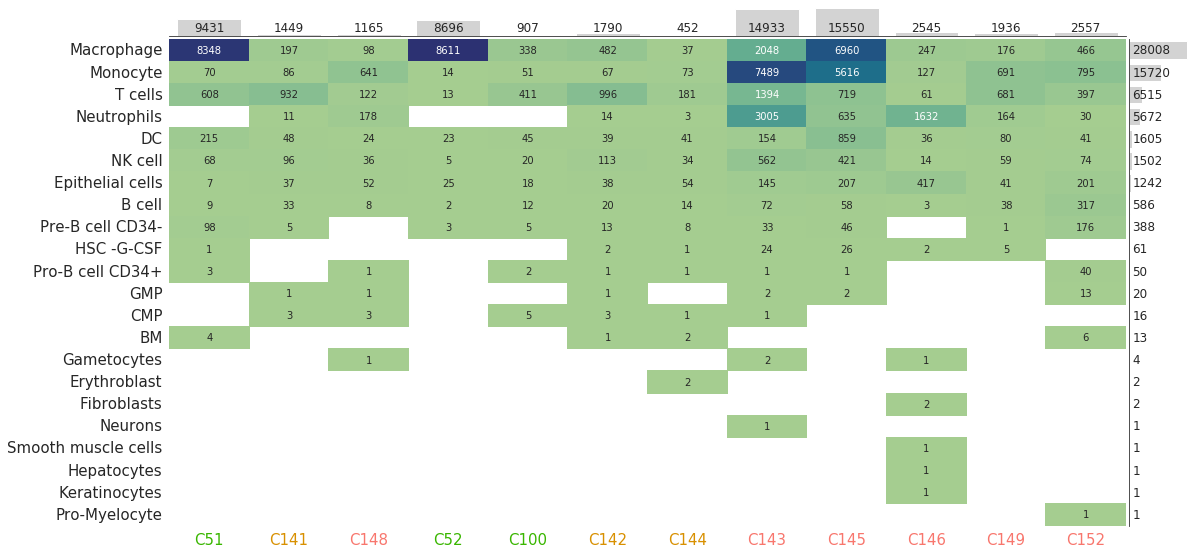

In [5]:
# Heatmap of cell type count distribution for different patients
scGRN.ana.plot_avail_cell_types(
    meta=full_meta,
    save_as=os.path.join(_FIG_HOME, 'EDA_cell_type_dist.pdf')
)

## Setting up additional data

We would also need additional data about TFs, NDEx networks and functional annotation of genes. 

In [6]:
# Setting pathways to auxiliary files
_NDEX_DATA = f'{_PROJ_HOME}/Data_home/data/ndex/'
_TF_LIST_lambert = f'{_PROJ_HOME}/Data_home/data/TF_lists/lambert2018.txt'
_TF_LIST_dorothea = f'{_PROJ_HOME}/Data_home/data/TF_lists/dorothea_regulons.tsv'

# Loading TFs, Lambert et al, 2018 is by default
TF_names = lambert_TF_names = pd.read_csv(_TF_LIST_lambert, header=None)[0].to_list()
dorothea_TF_names = list(
    pd.read_csv(_TF_LIST_dorothea, sep='\t') \
        .loc[lambda x: x['confidence'].isin(['A', 'B', 'C'])]['tf'].unique()
)

# Loading gene GO description - it was downloaded using ENSEMBL BioMart
GO_annotation = scGRN.ana.load_gene_func_db('GO')

## Setting up useful functions - mainly for `ipywidgets`

In [7]:
def data_fn_to_cell_type(data):
    """
    Transform data file identifier to cell type, e.g. "raw_data_Macrophage" -> "Macrophage"
    """
    
    return 'all_data' if data == 'raw_data' else data.replace('raw_data_', '')

def load_grn(pat, cell_type, net_type, filtered=None):
    """
    Load the NetworkX GRN with additional check if it is present in RAM.
    """
    
    tag = f'net_{net_type}' if filtered is None else f'filtered_net_{net_type}'
    
    try:
        G = grnboost2_meta[pat][cell_type][f'net_{net_type}']
    except KeyError:
        G = scGRN.ana.get_nx_graph(
            cell_type, net_type=net_type, pat=pat, 
            filtered=filtered, data_home=_DATA_HOME)
        
    return G

def load_adj_list(pat, cell_type, net_type, filtered=None):
    """
    Load the adjacency list GRN with additional check if it is present in RAM.
    """
    
    tag = f'adj_list_{net_type}' if filtered is None else f'filtered_adj_list_{net_type}'
    
    try:
        G = grnboost2_meta[pat][cell_type][f'adj_list_{net_type}']
    except KeyError:
        G = scGRN.ana.get_adj_list(cell_type, net_type=net_type, pat=pat, 
                                   filtered=filtered, data_home=_DATA_HOME)
        
    return G

def format_pat(p):
    """
    Format patient name `p` to a nice view, e.g. "C51 (C) - RAM", "C".
    """
    
    if p in ['all_data'] + _PAT_TYPES:
        return p
    else:
        is_RAM = ' - RAM' if p in _LOADED_PATIENTS else ''
        pat_type = f"{full_meta.loc[p, 'group']}"
        return f"{p} ({pat_type}){is_RAM}"

def format_data(p, ct, add_ram_tag=True):
    """
    Format data name corresponding to `p` (patient) and `ct` (cell type) to a nice view, e.g. "T_cells (2800 cells)""
    """
    
    if ct == 'all_data':
        tag = 'all_data'
        col_key = 'num_cells'
    else:
        col_key = tag = ct
            
    if p in ['all_data', 'C', 'M', 'S']:
        curr_meta = full_meta[full_meta['group'] == p] if p != 'all_data' else full_meta
        num_cells = int(curr_meta[col_key].sum())
    else:
        num_cells = int(full_meta.loc[p, col_key])
        
    is_RAM = ' - RAM' if tag in _LOADED_CELL_TYPES and add_ram_tag else ''
        
    return f'{tag} ({num_cells} cells){is_RAM}'

def gen_avail_data(_):
    """
    Generates a list of data options depending on passed information (for `ipywidgets`).
    """
    c_type_dropdown.options = [
        (
            format_data(p_dropdown.value, c_type), 
            c_type
        ) for c_type in scGRN.ana.get_avail_pat_nx(n_type_dropdown.value, p_dropdown.value, as_data_fn=False)
    ]
    
def gen_dropdowns():
    """
    Generate `ipywidgets` Dropdown objects to interact with jupyter notebook. 
    """
    _n_type_dropdown = Dropdown(
        description='Net type:', options=_NET_TYPES
    )
    _p_dropdown = Dropdown(
        description='Patient:', 
        options=[(format_pat(p), p) for p in _ALL_PATIENTS + ['C', 'M', 'S', 'all_data']]
    )
    _c_type_dropdown = Dropdown(
        description='Cell type:', 
        options=[
            (
                format_data(_ALL_PATIENTS[0], c_type), 
                c_type
            ) for c_type in scGRN.ana.get_avail_pat_nx('all', _ALL_PATIENTS[0], as_data_fn=False)
        ]
    )
    _p_dropdown.observe(gen_avail_data, names='value')
    _n_type_dropdown.observe(gen_avail_data, names='value')

    return _p_dropdown, _c_type_dropdown, _n_type_dropdown
    
sf_dropdown = Dropdown(
    description='Save figure:', options=[False, True]
)
fltrd_dropdown = Dropdown(
    description=f'Filtered (quantile threshold={_Q_THRESH}): ', options=[False, True]
)

# NDEx networks

We will download the interaction pathways from [`NDEx`](https://www.ndexbio.org/#/) database as a reference. We will save each network into `.cx` file and then load them here using [`NDEx2`](https://ndex2.readthedocs.io) API. All NDEx networks should be stored in `_NDEX_DATA`.

To download the NDEx network the user can use the `download_ndex_net.py` script:

```bash
python scGRN/network_analysis/download_ndex_net.py -i <NDEx_UUID> -f <save_to_folder> -n <file_name - arbitrary>
```

In this notebook, we will use the following NDEx networks:

| Type        | Name                                                                                                                                                      | Source                                                                                                         |
|-------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------|----------------------------------------------------------------------------------------------------------------|
| NK cells    | [NK Signaling](https://www.ndexbio.org/viewer/networks/b953a31b-9e15-11eb-9e72-0ac135e8bacf)                                                              | [causalbionet](http://causalbionet.com/Home/NetworkVisualization/#/!/networkGraph?ID=nk_signaling_2.0_hs)      |
| B cells     | [WP23 - B cell receptor signaling pathway - Homo sapiens](https://www.ndexbio.org/viewer/networks/00a68ce0-5c65-11ec-b3be-0ac135e8bacf)                   | [wikipathways](https://www.wikipathways.org/index.php/Pathway:WP23)                                            |
| B cells     | [B-cell Signaling](https://www.ndexbio.org/viewer/networks/51d0f5ed-9e16-11eb-9e72-0ac135e8bacf)                                                          | [causalbionet](http://causalbionet.com/Home/NetworkVisualization/#/!/networkGraph?ID=5df92bd801dd760eacf8ebf0) |
| DC cells    | [Dendritic Cell Signaling](https://www.ndexbio.org/viewer/networks/79b8d4a0-9e15-11eb-9e72-0ac135e8bacf)                                                  | [causalbionet](http://causalbionet.com/Home/NetworkVisualization/#/!/networkGraph?ID=765110535)                |
| Macrophages | [Macrophage polarization](https://www.ndexbio.org/viewer/networks/1b3873d6-8f9a-11e8-a4bf-0ac135e8bacf)                                                   | [signor](https://signor.uniroma2.it/pathway_browser.php?organism=&pathway_list=SIGNOR-M1M2&x=24&y=17)          |
| Macrophages | [Macrophage Signaling](https://www.ndexbio.org/viewer/networks/3285ca84-9e16-11eb-9e72-0ac135e8bacf)                                                      | [causalbionet](http://causalbionet.com/Home/NetworkVisualization/#/!/networkGraph?ID=1397028844)               |
| T cells     | [Cytotoxic T-cell Signaling](https://www.ndexbio.org/viewer/networks/bc49319e-9e14-11eb-9e72-0ac135e8bacf)                                                | [causalbionet](http://causalbionet.com/Home/NetworkVisualization/#/!/networkGraph?ID=5df9349f01dd760eacf98b55) |
| T cells     | [TCR signaling in nave CD8 T cells](https://www.ndexbio.org/viewer/networks/15a017bb-6196-11e5-8ac5-06603eb7f303)                                         | nci-pid                                                                                                        |
| T cells     | [WP2583 - T cell receptor and co-stimulatory signaling - Homo sapiens](https://www.ndexbio.org/viewer/networks/13b30225-5c6a-11ec-b3be-0ac135e8bacf)      | [wikipathways](https://www.wikipathways.org/index.php/Pathway:WP2583)                                          |
| T cells     | [T cell activation](https://www.ndexbio.org/viewer/networks/568d095e-1e5f-11e8-b939-0ac135e8bacf)                                                         | [signor](https://signor.uniroma2.it/pathway_browser.php?organism=&pathway_list=SIGNOR-TCA&x=26&y=15)           |
| T cells     | [TCR signaling in nave CD4 T cells](https://www.ndexbio.org/viewer/networks/0c2862fa-6196-11e5-8ac5-06603eb7f303)                                         | nci-pid                                                                                                        |
| T cells     | [WP5072 - Modulators of TCR signaling and T cell activation - Homo sapiens](https://www.ndexbio.org/viewer/networks/6ea1c5d6-5c74-11ec-b3be-0ac135e8bacf) | [wikipathways](https://www.wikipathways.org/index.php/Pathway:WP5072)                                          |
| T cells     | [Downstream signaling in nave CD8 T cells](https://www.ndexbio.org/viewer/networks/fc5e2bc0-b7be-11e9-8bb4-0ac135e8bacf)                                  | nci-pid                                                                                                        |
| T cells     | [WP69 - T-cell receptor (TCR) signaling pathway - Homo sapiens](https://www.ndexbio.org/viewer/networks/937153e5-5c66-11ec-b3be-0ac135e8bacf)             | [wikipathways](https://www.wikipathways.org/index.php/Pathway:WP69)                                            |
| Pathways    | [NF-KB Canonical](https://www.ndexbio.org/viewer/networks/3b9113b1-1e5f-11e8-b939-0ac135e8bacf)                                                           | [signor](https://signor.uniroma2.it/pathway_browser.php?organism=&pathway_list=SIGNOR-NFKBC&x=15&y=22)         |
| Pathways    | [PI3K_AKT Signaling](https://www.ndexbio.org/viewer/networks/0b6cbc27-97f1-11eb-9e72-0ac135e8bacf)                                                        | [signor](https://signor.uniroma2.it/pathway_browser.php?organism=&pathway_list=SIGNOR-PI3K-AKT&x=28&y=10)      |
| Pathways    | [Toll like receptors](https://www.ndexbio.org/viewer/networks/5a2ec134-1e5f-11e8-b939-0ac135e8bacf)                                                       | [signor](https://signor.uniroma2.it/pathway_browser.php?organism=&pathway_list=SIGNOR-TLR&x=14&y=16)           |

Each network is sorted by type, the files should be organized in the following way:

```
<_NDEX_DATA>
|-- B_cell
|   |-- B-cell\ Signaling.cx
|   `-- WP23\ -\ B\ cell\ receptor\ signaling\ pathway\ -\ Homo\ sapiens.cx
|-- DC
|   `-- Dendritic\ Cell\ Signaling.cx
|-- Macrophage
|   |-- Macrophage\ Signaling.cx
|   `-- Macrophage\ polarization.cx
|-- NK_cell
|   `-- NK\ Signaling.cx
|-- Pathways
|   |-- NF-KB\ Canonical.cx
|   |-- PI3K_AKT\ Signaling.cx
|   `-- Toll\ like\ receptors.cx
`-- T_cells
    |-- Cytotoxic\ T-cell\ Signaling.cx
    |-- Downstream\ signaling\ in\ nave\ CD8\ T\ cells.cx
    |-- T\ cell\ activation.cx
    |-- TCR\ signaling\ in\ nave\ CD4\ T\ cells.cx
    |-- TCR\ signaling\ in\ nave\ CD8\ T\ cells.cx
    |-- WP2583\ -\ T\ cell\ receptor\ and\ co-stimulatory\ signaling\ -\ Homo\ sapiens.cx
    |-- WP5072\ -\ Modulators\ of\ TCR\ signaling\ and\ T\ cell\ activation\ -\ Homo\ sapiens.cx
    `-- WP69\ -\ T-cell\ receptor\ (TCR)\ signaling\ pathway\ -\ Homo\ sapiens.cx
```

We will load the networks from `.cx` files and convert them to `NetworkX` objects.

In [8]:
# List the available `.cx` file networks
_NDEX_NET_FNAMES = glob(os.path.join(_NDEX_DATA, '*/*.cx'))
_NDEX_NET_NAMES = [net_fn[net_fn.find('ndex/')+5:-3] for net_fn in _NDEX_NET_FNAMES]

# Load NDEx networks
_NDEX_NETS = {
    net_n: scGRN.util.load_ndex_net(net_fn) for net_fn, net_n in zip(_NDEX_NET_FNAMES, _NDEX_NET_NAMES)
}

# Defining process-like nodes from NDEx networks
_NDEX_PROCESSES = [
    'Immune_response', 'T_cell_activation', 'F-actin_assembly',
     '"natural killer cell activation"', '"natural killer cell differentiation"',
     'Inflammation', 'Proliferation', 'Glycogen_synthesis', 'Protein_synthesis',
     'Survival', 'Interferon_Production', 'Immune_response', '"Pulmonary Disease, Chronic Obstructive"',
     '"CD8-positive, alpha-beta T cell proliferation"', '"lymphocyte chemotaxis"', '"T-cell migration"',
     '"Cytotoxic T-cell activation"', '"T cell activation"', '"M1 macrophage activation"',
     '"M2 macrophage activation"', '"Pulmonary Disease, Chronic Obstructive"', '"Smoke, cigarette"',
     '"monocyte chemotaxis"', '"macrophage activation"', '"cytoskeleton organization"',
     '"macrophage chemotaxis"', '"neutrophil chemotaxis"', '"apoptotic cell clearance"',
     'phagocytosis', 'M1_polarization', 'M2_polarization'
]
ndex_dropdown = Dropdown(
    description=f'NDEx net:', options=_NDEX_NET_NAMES
)

In [9]:
def draw_published_net(data):

    G = _NDEX_NETS[data]
    pos = nx.nx_agraph.pygraphviz_layout(G, prog="dot")
    
    f, ax = plt.subplots(figsize=(40, 20))      
    nx.draw(G, pos, with_labels=True, arrowstyle="->", arrowsize=30, edge_color='k',
                    node_color='pink', ax=ax, node_size=_NODE_SIZE)
    nx.draw_networkx_nodes(G.subgraph(TF_names), ax=ax, pos=pos, node_color='limegreen', 
                           node_size=_NODE_SIZE)
            
    ax.set_title(f'"{data}" network from NDEx', fontsize=20)
    plt.axis('off')
    
widget = interact(draw_published_net, data=_NDEX_NET_NAMES)

interactive(children=(Dropdown(description='data', options=('NK_cell/NK Signaling', 'B_cell/WP23 - B cell rece…

# Loading GRNBoost2 networks

In this section we will load the `GRNBoost2` networks into RAM. As mentioned previously, we will only load 6 patient GRNs to RAM: <span style="color:green">C51</span>, <span style="color:green">C52</span>, <span style="color:#8B8000">C141</span>, <span style="color:#8B8000">C142</span>, and <span style="color:red">C148</span>, <span style="color:red">C149</span>. The networks could have 3 types:

- gene-gene network (`all` tag) - contains inferred regulatory connections between all pairs of genes
- TF-target network (`TF` tag) - contains inferred connections between TFs and corresponding targets only (will not be loaded to RAM)
- enriched TF-target network (`ctx` tag) - contains motif-enriched inferred connections between TFs and corresponding targets only

Networks could be loaded in a form of adjacency lists from `.pickle` files or in a form of [`NetworkX`](https://networkx.org) objects from `.gpickle` files.

## Example of loading adjacency lists and NetworkX graphs

We will load only a limited amount of patient networks to the RAM memory to speed-up processing: <span style="color:green">C51</span>, <span style="color:#8B8000">C141</span>, and <span style="color:red">C148</span>. Additionally, we will load only "T cells", "Macrophages", "NK cells" and "Monocyte" GRNs from these patients.

In [10]:
# The dictionary that will store all networks
grnboost2_meta = {}

# Loading gene regulatory networks in various forms
p_bar = tqdm(_LOADED_PATIENTS)
for pat in p_bar:
    p_bar.set_description(f'Loading {pat} patient')
    grnboost2_meta[pat] = {}
    for cell_type in _LOADED_CELL_TYPES:

        # Filling field for corresponding `pat` and `cell_type`
        grnboost2_meta[pat][cell_type] = {
            'adj_list_all': scGRN.ana.get_adj_list(pat=pat, cell_type=cell_type, net_type='all'),  # gene-gene network, adjacency list
            'adj_list_ctx': scGRN.ana.get_adj_list(pat=pat, cell_type=cell_type, net_type='ctx'),  # enriched TF-target network, adjacency list
            'filtered_adj_list_all': scGRN.ana.get_adj_list(pat=pat, cell_type=cell_type, net_type='all', filtered=_Q_THRESH),  # filtered gene-gene network, adjacency list
            'filtered_adj_list_ctx': scGRN.ana.get_adj_list(pat=pat, cell_type=cell_type, net_type='ctx', filtered=_Q_THRESH),  # filtered enriched TF-target network, adjacency list
            'net_all': scGRN.ana.get_nx_graph(pat=pat, cell_type=cell_type, net_type='all'),  # gene-gene network, NetworkX object
            'net_ctx': scGRN.ana.get_nx_graph(pat=pat, cell_type=cell_type, net_type='ctx'),  # enriched TF-target network, NetworkX object
            'filtered_net_all': scGRN.ana.get_nx_graph(pat=pat, cell_type=cell_type, net_type='all', filtered=_Q_THRESH),  # filtered gene-gene network, NetworkX object
            'filtered_net_ctx': scGRN.ana.get_nx_graph(pat=pat, cell_type=cell_type, net_type='ctx', filtered=_Q_THRESH)  # filtered enriched TF-target network, NetworkX object
        }    

# Showing an example of patient network
ex_pat = 'C141'
ex_ct = 'all_data'
ex_gg_adj_list = grnboost2_meta[ex_pat][ex_ct]['adj_list_all']
ex_gg_net = grnboost2_meta[ex_pat][ex_ct]['net_all']
ex_gg_f_net = grnboost2_meta[ex_pat][ex_ct]['filtered_net_all']
ex_tft_adj_list = grnboost2_meta[ex_pat][ex_ct]['adj_list_ctx']
ex_tft_net = grnboost2_meta[ex_pat][ex_ct]['net_ctx']
ex_tft_f_net = grnboost2_meta[ex_pat][ex_ct]['filtered_net_ctx']
print(f'The example of 5 connections in gene-gene network ({ex_gg_net.number_of_nodes()} nodes and {ex_gg_net.number_of_edges()} edges):')
display(ex_gg_adj_list.head(3))
print(f'The example of 5 connections in TF-target network ({ex_tft_net.number_of_nodes()} nodes and {ex_tft_net.number_of_edges()} edges):')
display(ex_tft_adj_list.head(3))
print(
    f'After we applied quantile filtering of detected connections, the number changed:\n'
    f'   {ex_gg_net.number_of_edges()} -> {ex_gg_f_net.number_of_edges()} for gene-gene network\n'
    f'   {ex_tft_net.number_of_edges()} -> {ex_tft_f_net.number_of_edges()} for enriched TF-target network'
)

  0%|          | 0/3 [00:00<?, ?it/s]

The example of 5 connections in gene-gene network (17176 nodes and 3800400 edges):


,TF,target,importance,regulation,rho
0,C1QB,C1QC,100.666598,1,0.929949
1,HLA-DPB1,HLA-DPA1,99.704634,1,0.922994
2,C1QC,C1QB,90.717833,1,0.929949


The example of 5 connections in TF-target network (12478 nodes and 69367 edges):


,TF,target,importance,regulation,rho
0,AHR,NECTIN2,0.496191,1.0,0.139634
1,AHR,EIF3A,0.867158,1.0,0.120264
2,AHR,STON2,2.024488,1.0,0.128771


After we applied quantile filtering of detected connections, the number changed:
   3800400 -> 190020 for gene-gene network
   69367 -> 3469 for enriched TF-target network


## Availability of NetworkX graphs for different datasets

In [11]:
# Getting adjacency list/NetworkX object availability matrices
_AVAIL_ADJ_LISTs = scGRN.ana.get_avail_adj_lists(
    data_home=_DATA_HOME,
    meta_file=_FMETA
)
_AVAIL_Gs = scGRN.ana.get_avail_nx_graphs(
    data_home=_DATA_HOME,
    meta_file=_FMETA
)

# Visualizing the GRN availability matrix
for net_type in _NET_TYPES:
    print(f"{colored(net_type, 'cyan')}-type networks")
    display(scGRN.util.style_bool_df(_AVAIL_Gs[net_type]))

# Printing the legend
check, missing, cross = u'\u2713', '?', u'\u2715'  # green, red, #8B8000
print(colored('Legend:', 'green'))
print('all_data: The aggregated data, e.g. ("all_data", "Macrophage") - all macrophages, ("C152", "all_data") - all cells from C152.')
print(f'{check}: Data is processed and ready for use')
print(f'{missing}: Failed to detect the data file, although the corresponding cell type is present in patient')
print(f'{cross}: The corresponding cell type is not present in patient')

all-type networks


,all_data,Macrophage,T_cells,DC,Pre-B_cell_CD34-,Monocyte,NK_cell,B_cell,Epithelial_cells,BM,Pro-B_cell_CD34+,HSC_-G-CSF,CMP,Neutrophils,GMP,Erythroblast,Gametocytes,Neurons,Fibroblasts,Smooth_muscle_cells,Hepatocytes,Keratinocytes,Pro-Myelocyte
all_data,?,✓,✓,✓,✓,✓,✓,✓,✓,?,?,?,?,✓,?,?,?,?,?,?,?,?,?
C,✓,✓,✓,✓,✓,✓,✓,✓,✓,?,?,?,?,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕
M,✓,✓,✓,✓,✓,✓,✓,✓,✓,?,?,?,?,✓,?,?,✕,✕,✕,✕,✕,✕,✕
S,?,✓,✓,✓,✓,✓,✓,✓,✓,?,?,?,?,✓,?,✕,?,?,?,?,?,?,?
C51,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕
C52,✓,✓,✓,✓,✓,✓,✓,✓,✓,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕
C100,✓,✓,✓,✓,✓,✓,✓,✓,✓,✕,✓,✕,✓,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕
C141,✓,✓,✓,✓,✓,✓,✓,✓,✓,✕,✕,✕,✓,✓,✓,✕,✕,✕,✕,✕,✕,✕,✕
C142,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✕,✕,✕,✕,✕,✕,✕,✕
C144,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✕,✓,✕,✕,✕,✕,✕,✕,✕


TF-type networks


,all_data,Macrophage,T_cells,DC,Pre-B_cell_CD34-,Monocyte,NK_cell,B_cell,Epithelial_cells,BM,Pro-B_cell_CD34+,HSC_-G-CSF,CMP,Neutrophils,GMP,Erythroblast,Gametocytes,Neurons,Fibroblasts,Smooth_muscle_cells,Hepatocytes,Keratinocytes,Pro-Myelocyte
all_data,✓,✓,✓,✓,✓,✓,✓,✓,✓,?,?,?,?,✓,?,?,?,?,?,?,?,?,?
C,✓,✓,✓,✓,✓,✓,✓,✓,✓,?,?,?,?,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕
M,✓,✓,✓,✓,✓,✓,✓,✓,✓,?,?,?,?,✓,?,?,✕,✕,✕,✕,✕,✕,✕
S,✓,✓,✓,✓,✓,✓,✓,✓,✓,?,?,?,?,✓,?,✕,?,?,?,?,?,?,?
C51,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕
C52,✓,✓,✓,✓,✓,✓,✓,✓,✓,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕
C100,✓,✓,✓,✓,✓,✓,✓,✓,✓,✕,✓,✕,✓,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕
C141,✓,✓,✓,✓,✓,✓,✓,✓,✓,✕,✕,✕,✓,✓,✓,✕,✕,✕,✕,✕,✕,✕,✕
C142,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✕,✕,✕,✕,✕,✕,✕,✕
C144,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✕,✓,✕,✕,✕,✕,✕,✕,✕


ctx-type networks


,all_data,Macrophage,T_cells,DC,Pre-B_cell_CD34-,Monocyte,NK_cell,B_cell,Epithelial_cells,BM,Pro-B_cell_CD34+,HSC_-G-CSF,CMP,Neutrophils,GMP,Erythroblast,Gametocytes,Neurons,Fibroblasts,Smooth_muscle_cells,Hepatocytes,Keratinocytes,Pro-Myelocyte
all_data,✓,✓,✓,✓,✓,✓,✓,✓,✓,?,?,?,?,✓,?,?,?,?,?,?,?,?,?
C,✓,✓,✓,✓,✓,✓,✓,✓,✓,?,?,?,?,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕
M,✓,✓,✓,✓,✓,✓,✓,✓,✓,?,?,?,?,✓,?,?,✕,✕,✕,✕,✕,✕,✕
S,✓,✓,✓,✓,✓,✓,✓,✓,✓,?,?,?,?,✓,?,✕,?,?,?,?,?,?,?
C51,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,?,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕
C52,✓,✓,✓,✓,✓,✓,✓,?,✓,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕
C100,✓,✓,✓,✓,✓,✓,✓,✓,✓,✕,?,✕,✓,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕
C141,✓,✓,✓,✓,✓,✓,✓,✓,✓,✕,✕,✕,✓,✓,?,✕,✕,✕,✕,✕,✕,✕,✕
C142,✓,✓,✓,✓,✓,✓,✓,✓,✓,?,?,?,✓,✓,?,✕,✕,✕,✕,✕,✕,✕,✕
C144,✓,✓,✓,✓,✓,✓,✓,✓,✓,?,?,?,?,✓,✕,?,✕,✕,✕,✕,✕,✕,✕


Legend:
all_data: The aggregated data, e.g. ("all_data", "Macrophage") - all macrophages, ("C152", "all_data") - all cells from C152.
✓: Data is processed and ready for use
?: Failed to detect the data file, although the corresponding cell type is present in patient
✕: The corresponding cell type is not present in patient


# Exploratory data analysis

We are finally ready to explore the GRNs computed for different subsets of data! We will start by looking at the basic statistics to describe the obtained networks. We will **not** use filtered GRNs for now to describe the whole set of inferred gene-gene associations.

## Aggregated statistics among all networks

Below we will compute the common graph statistical characteristics for gene-gene networks (`net_type = 'all'`) and enriched TF-target networks (`net_type = 'ctx'`) such as:
- Number of nodes/edges
- Average degree
- Average path length
- Radius/diameter

To describe network edges/nodes we will visualize:
- Link importances (median/STD)
- Number of detected TFs

We will have to load all the networks and compute the metrics above. The cell below will take ~5 minutes to execute this with `n_jobs = 48`.

In [18]:
%%time

graph_stats = scGRN.ana.get_graph_stats(meta=full_meta, n_jobs=_N_JOBS, filtered=_Q_THRESH)

CPU times: user 15.7 s, sys: 17.8 s, total: 33.5 s
Wall time: 9min 13s


### Common graph properties of GRNs

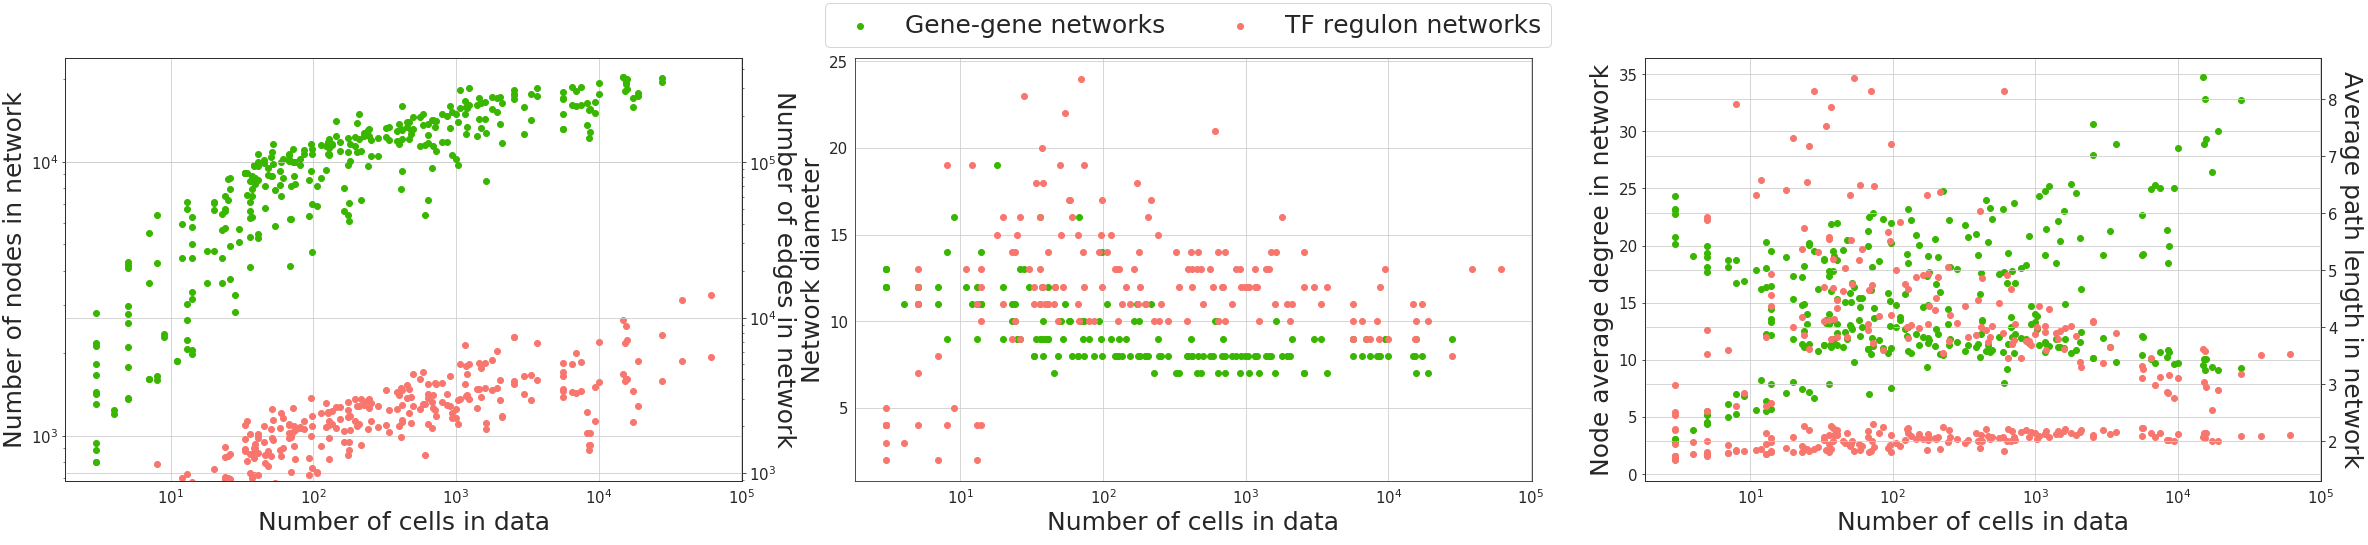

In [19]:
save_as = os.path.join(_FIG_HOME, 'EDA_all_graph_properties.pdf')

# Plotting graph properties against number of cells for all GRNs
scGRN.ana.graph_stats_vs_num_cells(graph_stats, save_as=save_as);

### Common properties of GRN edges

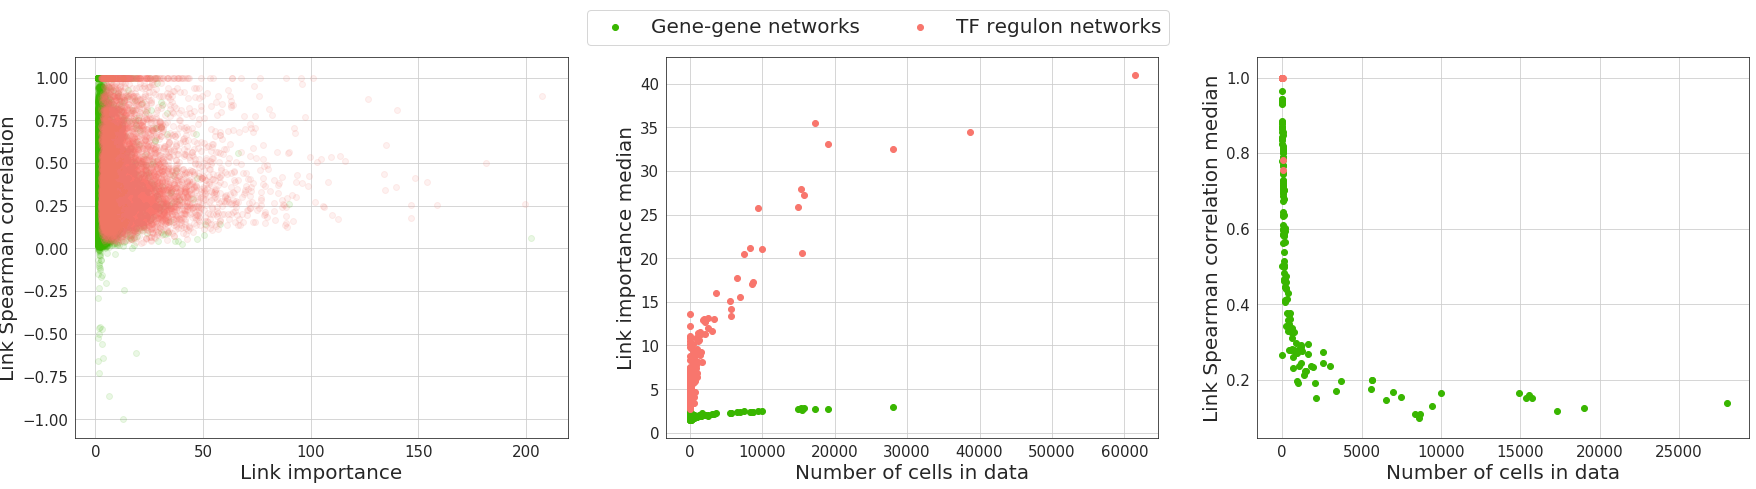

In [20]:
save_as = os.path.join(_FIG_HOME, 'EDA_all_edge_graph_properties.pdf')

# Plotting graph edge properties against number of cells for all GRNs
scGRN.ana.graph_edge_stats_vs_num_cells(graph_stats, save_as=save_as);

### Distribution of the number of inferred regulons

We will show below the distribution of the number of inferred regulons.

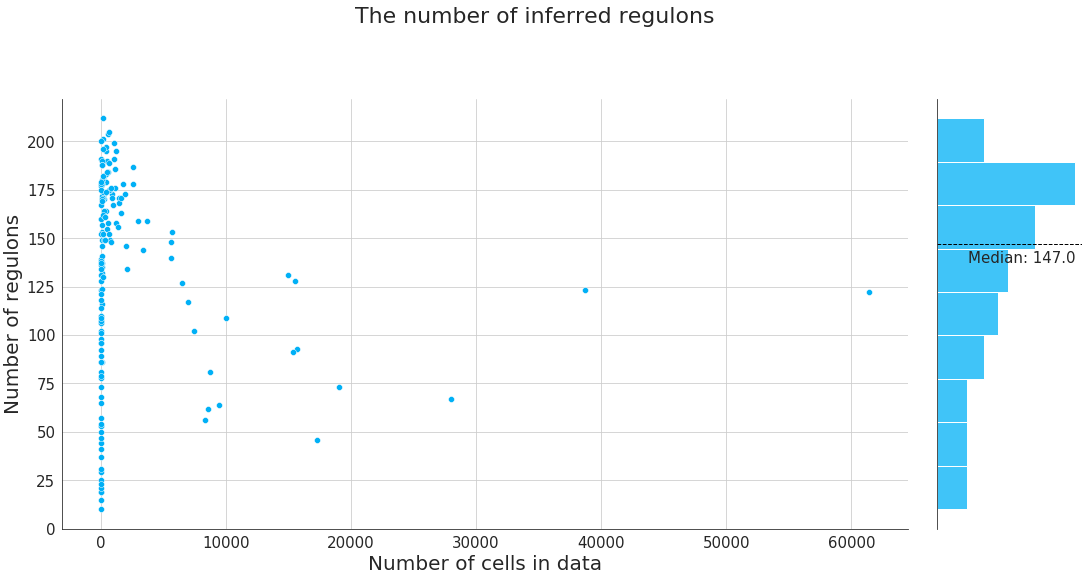

In [21]:
save_as = os.path.join(_FIG_HOME, 'EDA_dist_num_regulons.pdf')

# Plotting number of inferred regulons against the number of cells
scGRN.ana.graph_num_regulons_vs_num_cells(graph_stats, save_as=save_as);

## Number of cells/nodes/edges for a specific patient GRN

In [12]:
def GRN_stats(pat, net_type, save_fig):
    """
    Bar plot to show the cell count (in scRNA-seq data), number of nodes and number of edges for a specific patient GRN.
    
    :param pat: Patient ID
    :param net_type: Network type
    :param save_fig: Whether to save the figure
    """

    # Getting the cell count for available cell types
    cell_counts = full_cell_type_dist.loc[pat].dropna().astype('int32').rename('num_cells')
    cell_counts['all'] = cell_counts.sum()

    # Getting the number of nodes/edges for corresponding networks
    data_properties = pd.DataFrame(
        index=cell_counts.index,
        columns=['num_nodes', 'num_edges']
    )
    for cell_type in cell_counts.index:
        # Trying to get from RAM
        curr_G = load_grn(pat, cell_type, net_type)
        data_properties.loc[cell_type] = [curr_G.number_of_nodes(), curr_G.number_of_edges()]
    data_properties = data_properties.join(cell_counts).sort_values('num_cells', ascending=False).iloc[:, ::-1]

    titles = [
        'Initial number of cells',
        'Number of edges',
        'Number of nodes'
    ]
    
    with sns.axes_style("white"):
    
        axes = data_properties.plot(kind='bar', legend=None, sharex=True, subplots=True, figsize=(20, 10))
        for ax, title in zip(axes, titles):

            for bar in ax.patches:
                ax.annotate(bar.get_height(), (bar.get_x() + bar.get_width() / 2,
                            bar.get_height()), ha='center', va='center',
                            size=15, xytext=(0, 8), textcoords='offset points', transform=ax.transAxes)

            ax.grid(True)
            ax.set_title(title)

    axes[2].set_xlabel('Cell type')
    axes[1].set_ylabel('Count')
    axes[2].set_xticklabels(ax.get_xticklabels(), rotation=45)

    plt.gcf().suptitle(f'The GRN properties: pat={pat}, net_type={net_type}', y=1.03, fontsize=22)
    plt.tight_layout()

    if save_fig:
        plt.savefig(
            os.path.join(_ALL_FIG_DIRS[pat], f'EDA_{pat}_{net_type}_cell_node_edge_counts.pdf'), 
            dpi=200, bbox_inches='tight'
        )

n_type_dropdown = Dropdown(
    description='Net type:', options=_NET_TYPES
)
p_dropdown = Dropdown(
    description='Patient:', 
    options=[(format_pat(p), p) for p in _ALL_PATIENTS]
)
    
widget = interact(GRN_stats, pat=p_dropdown, net_type=n_type_dropdown, save_fig=sf_dropdown)

interactive(children=(Dropdown(description='Patient:', options=(('C51 (C) - RAM', 'C51'), ('C141 (M) - RAM', '…

## Histogram of link importances and Spearman correlations

In [13]:
def hist_importance_corr(net_type, pat, cell_type, save_fig):
    """
    Histogram of obtained GRNBoost2 connection importance between genes and corresponding Spearman correlation.
    
    :param net_type: Network type
    :param pat: Patient ID
    :param cell_type: Provided cell type
    :param save_fig: Whether to save the figure
    """
    
    top_n = 3
    color_align_imp_corr = False  # color-code the correspondence between importance and correlation
    n_bins = 100
    df = load_adj_list(pat, cell_type, net_type)
    num_links = len(df)
    cmap=plt.cm.plasma
    
    # Calculate the various statistics
    pos_links, neg_links = (df["rho"] > 0).sum(), (df["rho"] < 0).sum()
    top_tfs = df[['TF', 'target']].groupby('TF').size().nlargest(top_n)
    top_targets = df[['TF', 'target']].groupby('target').size().nlargest(top_n)
    import_50, import_75, import_max = df['importance'].median(), df['importance'].quantile(0.75), df['importance'].max()
    top_high_tfs = df.loc[lambda x: x.importance > import_50][['TF', 'target']].groupby('TF').size().nlargest(top_n)
    top_high_targets = df.loc[lambda x: x.importance > import_50][['TF', 'target']].groupby('target').size().nlargest(top_n)    
    
    print(f'The chosen dataset is cell_type="{cell_type}", net_type="{net_type}" which contains {num_links} connections.')
    print(f'Positive connections - {pos_links} ({pos_links/num_links*100:.1f} %), '
          f'negative connections - {neg_links} ({neg_links/num_links*100:.1f} %)')
    print(f'The dataset contains {df["TF"].nunique()} TFs out of {len(TF_names) if "TF" in net_type else ex_df.shape[1]} and {df["target"].nunique()} targets')
    print(f'TFs with maximum connections: {top_tfs.index[0]} ({top_tfs[0]}), {top_tfs.index[1]} ({top_tfs[1]}), {top_tfs.index[2]} ({top_tfs[2]}); '
          f'targets with maximum connections: {top_targets.index[0]} ({top_targets[0]}), {top_targets.index[1]} ({top_targets[1]}), {top_targets.index[2]} ({top_targets[2]})')
    print(f'TFs with maximum connections (importance > median): {top_high_tfs.index[0]} ({top_high_tfs[0]}), {top_high_tfs.index[1]} ({top_high_tfs[1]}), {top_high_tfs.index[2]} ({top_high_tfs[2]}); '
          f'targets with maximum connections (importance > median): {top_high_targets.index[0]} ({top_high_targets[0]}), {top_high_targets.index[1]} ({top_high_targets[1]}), {top_high_targets.index[2]} ({top_high_targets[2]})..')
    print()
    display(df.describe().drop(index=['count'], columns=['regulation']).T)
    print()
    
    # Plotting gene-gene link importance distribution
    f, ax = plt.subplots(1, 2, figsize=(20, 8))

    # Plotting histogram distribution of the GRNBoost2 importance
    if color_align_imp_corr:
        y, x = np.histogram(df['importance'], n_bins, density=False)
        colors = [cmap((x_i - x.min()) / (x.max() - x.min())) for x_i in x]
        ax[0].bar(x[:-1], y, color=colors, width=x[1]-x[0])
        ax[0].set_yscale('log')
    else:
        df['importance'].plot(ax=ax[0], bins=n_bins, kind='hist', logy=True)
    ax[0].set_title(f'GRNBoost2-inferred gene-gene connection importance')
    ax[0].set_xlabel('Gene-gene connection importance')
    
    # Plotting histrogram distribution of Spearman correlation
    if color_align_imp_corr:
        df_rho = df['rho'] if not np.all(np.isfinite(df['rho'])) else df['rho'][np.isfinite(df['rho'])]
        y_rho, x_rho = np.histogram(df_rho, n_bins, density=False)
        colors_rho = [None]*len(x)
        for i, rho in enumerate(x_rho):
            importance_closest = df.iloc[(df['rho']-rho).abs().argsort()[:3]]['importance'].mean()
            id_closest = (np.abs(x - importance_closest)).argmin()
            colors_rho[i] = colors[id_closest]
        ax[1].bar(x_rho[:-1], y_rho, color=colors_rho, width=x_rho[1] - x_rho[0])
        ax[1].set_yscale('log')
    else:
        df['rho'].plot(ax=ax[1], bins=n_bins, density=True, kind='hist', logy=True)
    ax[1].set_title(f'Correlation between linked genes')
    ax[1].set_xlabel('Spearman correlation')
    
    f.suptitle(f'Distributions of GRN edge properties: pat={pat}, net_type={net_type}, cell_type={cell_type}', fontsize=20)
    
    if save_fig:
        plt.savefig(os.path.join(_ALL_FIG_DIRS[pat], f'EDA_{pat}_{data}_{data_type}_genstats.pdf'), dpi=200, bbox_inches='tight') 
        

p_dropdown, c_type_dropdown, n_type_dropdown = gen_dropdowns()

widget = interact(
    hist_importance_corr, 
    net_type=n_type_dropdown, 
    pat=p_dropdown, 
    cell_type=c_type_dropdown, 
    save_fig=sf_dropdown
)

interactive(children=(Dropdown(description='Net type:', options=('all', 'TF', 'ctx'), value='all'), Dropdown(d…

#### Cell count between patient types

In [14]:
def pat_type_cell_count(c_type, save_fig):
    """
    Plot cell count for different patient types ('C', 'M', 'S') with given `c_type`.
    
    :param c_type: Provided cell type
    :param save_fig: Whether to save the figure
    """
    with sns.axes_style("white"):
        f, ax = plt.subplots(figsize=(15, 7))
        full_meta.groupby('group')[c_type].sum().plot(
            kind='bar', ax=ax, rot=0, color=[colors['green'], colors['yellow'], colors['red']]
        )
        plt.xlabel('Patient type')
        plt.ylabel('Number of cells')
        
        ax.grid(True)
        plt.title(f'The cell count for "{c_type}" cells')
        
        if save_fig:
            plt.savefig(os.path.join(_FIG_HOME, f'{c_type}_cell_count_different_pat_types.pdf'))
    
c_type_dropdown = Dropdown(
    description='Cell type:', 
    options=[
        (
            format_data('all_data', c_type, add_ram_tag=False), 
            c_type
        ) for c_type in full_cell_type_dist.columns
    ]
)

widget = interact(
    pat_type_cell_count, 
    c_type=c_type_dropdown, 
    save_fig=sf_dropdown
)

interactive(children=(Dropdown(description='Cell type:', options=(('Macrophage (28008 cells)', 'Macrophage'), …

#### Venn diagram of gene-gene link co-occurence between patient types

In [15]:
def venn_link_cooccur(c_type_1, c_type_2, save_fig):
    """
    Plot 2 Venn diagrams (per chosen cell type) to show co-occurent GRN links (in 'all' GRNs) across various patient types ('C', 'M', 'S').
    
    :param c_type_1: Provided cell type (1)
    :param c_type_2: Provided cell type (2)
    :param save_fig: Whether to save the figure
    """
    
    top_n = 5
    n_bins = 100
    fontsize = 25
    cell_types = [c_type_1, c_type_2]
    cmap = ListedColormap([colors['green'], colors['yellow'], colors['red']])

    adj_lists = {
        ct: {
            t: load_adj_list(pat=t, cell_type=ct, net_type='all', filtered=_Q_THRESH) for t in _PAT_TYPES
        } for ct in cell_types
    }

    f, ax = plt.subplots(1, 2, figsize=(15, 7))

    for i, (ct, curr_adj_lists) in enumerate(adj_lists.items()):

        venn({
            t: set(zip(adj_list['TF'], adj_list['target'])) for t, adj_list in curr_adj_lists.items()
        }, fmt='{percentage:.1f}%', hint_hidden=False, ax=ax[i], cmap=cmap)
        ax[i].set_title(ct, fontsize=fontsize, fontweight='bold')
        ax[i].get_legend().remove()

    f.legend(
        handles = [
            mpatches.Patch(color=c, label=t, alpha=0.4) 
            for c, t in zip([colors['green'], colors['yellow'], colors['red']], _PAT_TYPES)
        ], 
        ncol=3, loc='upper center')

    if save_fig:
            plt.savefig(os.path.join(_FIG_HOME, f'{c_type_1}_{c_type_2}_pat_types_venn.pdf'), bbox_inches='tight')
            
c_types = _ALL_CELL_TYPES
c_type_1_dropdown = Dropdown(
    description='Cell type (1):', 
    options=c_types
)
c_type_2_dropdown = Dropdown(
    description='Cell type (2):', 
    options=c_types[1:] + [c_types[0]]
)

widget = interact(
    venn_link_cooccur, 
    c_type_1=c_type_1_dropdown, 
    c_type_2=c_type_2_dropdown,
    save_fig=sf_dropdown
) 

interactive(children=(Dropdown(description='Cell type (1):', options=('Macrophage', 'T_cells', 'DC', 'Pre-B_ce…

#### Venn diagram of common TFs between patient types

In [16]:
def venn_TF_present(c_type_1, c_type_2, save_fig):
    """
    Plot 2 Venn diagrams (per chosen cell type) to show activated TFs (in 'ctx' GRNs) across various patient types ('C', 'M', 'S').
    
    :param c_type_1: Provided cell type (1)
    :param c_type_2: Provided cell type (2)
    :param save_fig: Whether to save the figure
    """
    
    max_freq = 5
    fontsize = 30
    cell_types = [c_type_1, c_type_2]
    
    TFs = {
        ct: {
            t: reduce(
                lambda x, y: x + y, 
                load_adj_list(pat=t, cell_type=ct, net_type='ctx', filtered=_Q_THRESH)[['TF', 'target']]
                    .groupby('TF').nunique().reset_index()
                    .assign(scaled_num=lambda x: scGRN.util.scale_int(x.target, 1, max_freq))
                    .apply(lambda row: [row['TF']]*row['scaled_num'], axis=1)
            ) for t in _PAT_TYPES
        } for ct in cell_types
    }
    
    word_to_frequency = {
        ct: dict(Counter(list(
            reduce(lambda x, y: x + y, list(TFs[ct].values()))
        ))) for ct in cell_types
    }
    
    # Cut-off the prevalence of highly-active TFs
    word_to_frequency = {
        ct: {
            tf: (num if num < max_freq else max_freq) for tf, num in word_to_frequency[ct].items()
        } for ct in cell_types
    }
    
    f, ax = plt.subplots(1, len(cell_types), figsize=(25, 10))

    for a, ct in zip(ax, cell_types):
        matplotlib_venn_wordcloud.venn3_wordcloud(
            [set(tf_list) for tf_list in TFs[ct].values()], 
            set_labels=_PAT_TYPES,
            set_edgecolors=[colors['green'], colors['yellow'], colors['red']],
            ax=a, 
            word_to_frequency=word_to_frequency[ct],
            wordcloud_kwargs=dict(min_font_size=6, width=1200, height=800)
        )

        a.set_title(ct, fontsize=fontsize, fontweight='bold')
        
    if save_fig:
        plt.savefig(os.path.join(_FIG_HOME, f'{c_type_1}_{c_type_2}_pat_types_venn.pdf'), bbox_inches='tight')
            
c_types = _ALL_CELL_TYPES
c_type_1_dropdown = Dropdown(
    description='Cell type (1):', 
    options=c_types
)
c_type_2_dropdown = Dropdown(
    description='Cell type (2):', 
    options=c_types[1:] + [c_types[0]]
)

widget = interact(
    venn_TF_present, 
    c_type_1=c_type_1_dropdown, 
    c_type_2=c_type_2_dropdown,
    save_fig=sf_dropdown
) 

interactive(children=(Dropdown(description='Cell type (1):', options=('Macrophage', 'T_cells', 'DC', 'Pre-B_ce…

## Graph visualizations
### Visualization of connections with highest importance

In [17]:
def top_links_graph(net_type, pat, cell_type, top_n, save_fig):
    """
    Visualize a subgraph of GRN with top importance links.
    
    :param net_type: Network type
    :param pat: Patient ID
    :param cell_type: Provided cell type
    :param top_n: The number of top links to visualize
    :param save_fig: Whether to save the figure
    """
    
    full_G = load_grn(pat, cell_type, net_type)
    label_edges = False
    alpha = 0.5
    if_alpha_edges = False
    
    out_link_dict = {(st, end): info['importance'] for st, end, info in full_G.edges(data=True)}
    out_dict_sorted = dict(sorted(out_link_dict.items(), key=lambda x: x[1], reverse=True)[:top_n])
    edges = list(out_dict_sorted.keys())
    G = full_G.edge_subgraph(edges)
    
    pos = nx.nx_agraph.pygraphviz_layout(G, prog="dot")  # nx.nx.spring_layout(G, seed=_SEED, k=0.2, iterations=20)
    cmap = sns.light_palette("seagreen", as_cmap=True) 
    
    f, ax = plt.subplots(figsize=(30, 10))   
    
    scGRN.ana.draw_graph(
        G, pos=pos, ax=ax, TF_names=TF_names, alpha=alpha,
        label_edges=label_edges, node_size=_NODE_SIZE, 
        if_alpha_edges=if_alpha_edges, cmap=cmap
    )
    
    f.suptitle(f'Top {top_n} links with highest importances: pat={pat}, cell_type={cell_type}, net_type={net_type}\n'
               f'TF are blue, other genes are yellow', fontsize=20)
    
    plt.tight_layout()
    
    if save_fig:
        plt.savefig(os.path.join(_ALL_FIG_DIRS[pat], f'{pat}_{cell_type}_{net_type}_top_{top_n}_links.pdf'), bbox_inches='tight', dpi=200)

p_dropdown, c_type_dropdown, n_type_dropdown = gen_dropdowns()
        
widget = interact(
    top_links_graph,
    net_type=n_type_dropdown,
    pat=p_dropdown, 
    cell_type=c_type_dropdown, 
    top_n=IntSlider(min=1, max=151, step=1, value=50),
    save_fig=sf_dropdown,
)

interactive(children=(Dropdown(description='Net type:', options=('all', 'TF', 'ctx'), value='all'), Dropdown(d…

### Visualization of specific TFs and their top targets (enriched TF-target networks only)

In [18]:
# Please choose your TFs
TFs = 'STAT1, ETS1, JUND, REL, IRF7, ELF1'.split(', ')

def fixed_TFs_top_targets_graph(net_type, pat, cell_type, TFs, top_n, save_fig):
    """
    Visualize a subgraph of GRN with chosen TFs and their top importance targets (for enriched TF-target networks only).

    :param net_type: Network type
    :param pat: Patient ID
    :param cell_type: Provided cell type
    :param TFs: A list of transcription factors to visualize
    :param top_n: The number of top links to visualize
    :param save_fig: Whether to save the figure
    """
    
    full_G = load_grn(pat, cell_type, net_type)
    label_edges = False
    alpha = 0.5
    if_alpha_edges = False
    
    # Check if all passed TFs are present in the graph
    if not all([tf in full_G.nodes() for tf in TFs]):
        warnings.warn(
            f"""Next TFs are not present in the graph:"""
            f"""{", ".join([f"'{tf}'" for tf in TFs if tf not in full_G.nodes()])}"""
        )
    TFs_to_plot = [tf for tf in TFs if tf in full_G.nodes()]
    
    # Subsetting the initial graph to only chosen TFs and targets
    edges = []
    for TF in TFs_to_plot:
        out_link_dict = {end: info['importance'] for st, end, info in full_G.edges(TF, data=True)}
        out_dict_sorted = dict(sorted(out_link_dict.items(), key=lambda x: x[1], reverse=True)[:top_n])
        edges += [(TF, target) for target in out_dict_sorted.keys()]
    G = full_G.edge_subgraph(edges)
    
    pos = nx.nx.spring_layout(G, seed=_SEED, k=0.2, iterations=20)  # nx.nx_agraph.pygraphviz_layout(G, prog="dot")
    cmap = sns.light_palette("seagreen", as_cmap=True)
    
    f, ax = plt.subplots(figsize=(30, 15))   
    
    scGRN.ana.draw_graph(
        G, pos=pos, ax=ax, TF_names=TFs_to_plot, 
        label_edges=label_edges, node_size=_NODE_SIZE, 
        if_alpha_edges=if_alpha_edges, cmap=cmap
    )
    
    ax.set_title(f'Graph with TFs (in blue) and their top {top_n} targets (in yellow) with highest importances: '
                 f'pat={pat}, cell_type={cell_type}, net_type={net_type}\n'
                 f'TFs: {", ".join(TFs_to_plot)}', fontsize=20)
    
    if save_fig:
        plt.savefig(os.path.join(_ALL_FIG_DIRS[pat], f'{pat}_{cell_type}_{net_type}_top_{top_n}_tf_target_link_importances.pdf'), bbox_inches='tight', dpi=200) 

p_dropdown, c_type_dropdown, n_type_dropdown = gen_dropdowns()
        
widget = interact(
    fixed_TFs_top_targets_graph,
    net_type=n_type_dropdown,
    pat=p_dropdown, 
    cell_type=c_type_dropdown, 
    TFs=fixed(TFs),
    top_n=IntSlider(min=1, max=151, step=1, value=10),
    save_fig=sf_dropdown
)

interactive(children=(Dropdown(description='Net type:', options=('all', 'TF', 'ctx'), value='all'), Dropdown(d…

### Visualization of a gene subset of interest

In [19]:
genes = ['NFKB1', 'STAT3', 'MYC', 'ETS1', 'FOS'] 

def genes_from_list_graph(net_type, pat, cell_type, filtered, genes, save_fig):
    """
    Visualize a subgraph of GRN with chosen genes.

    :param pat: Patient ID
    :param cell_type: Provided cell type
    :param net_type: Network type
    :param filtered: True if get filtered GRN, False otherwise
    :param genes: A list of genes to visualize
    :param save_fig: Whether to save the figure
    """
    
    full_G = load_grn(pat, cell_type, net_type, filtered=_Q_THRESH if filtered else None)
    label_edges = False
    alpha = 0.5
    if_alpha_edges = False
    
    # Check if all genes are present in the graph
    if not all([g in full_G.nodes() for g in genes]):
        warnings.warn(
            f"""Next genes are not present in the graph: """
            f"""{", ".join([f"'{g}'" for g in genes if g not in full_G.nodes()])}"""
        )
        
    genes_to_plot = [g for g in genes if g in full_G.nodes()]

    G = full_G.subgraph(genes_to_plot)
    
    pos = nx.nx_agraph.pygraphviz_layout(G, prog="dot")  # nx.nx.spring_layout(G, seed=seed, k=0.2, iterations=20)
    cmap = plt.cm.plasma
    
    f, ax = plt.subplots(figsize=(30, 15))   
    
    scGRN.ana.draw_graph(
        G, pos=pos, ax=ax, TF_names=TF_names, 
        label_edges=label_edges, node_size=_NODE_SIZE, 
        if_alpha_edges=if_alpha_edges, cmap=cmap
    )
        
    ax.set_title(f'Graph with fixed genes of interest: pat={pat}, cell_type={cell_type}, net_type={net_type})\n'
                 f'TF are blue, other genes are yellow', fontsize=20)
    
    if save_fig:
        plt.savefig(os.path.join(_ALL_FIG_DIRS[pat], f'{pat}_{cell_type}_{net_type}_genes_from_list.png'), bbox_inches='tight', dpi=200) 
        
p_dropdown, c_type_dropdown, n_type_dropdown = gen_dropdowns()
        
widget = interact(
    genes_from_list_graph,
    net_type=n_type_dropdown,
    pat=p_dropdown, 
    cell_type=c_type_dropdown, 
    filtered=fltrd_dropdown,
    genes=fixed(genes),
    save_fig=sf_dropdown
)

interactive(children=(Dropdown(description='Net type:', options=('all', 'TF', 'ctx'), value='all'), Dropdown(d…

### Comparison between inferred GRN and NDEx network

In [20]:
def GRN_vs_ndex_graph(ndex_net, net_type, pat, cell_type, save_fig):
    """
    Compare the inferred GRN with similar NDEx network (looking at the same nodes and edges).

    :param ndex_net: NDEx network identifier
    :param pat: Patient ID
    :param net_type: Network type
    :param cell_type: Provided cell type
    :param save_fig: Whether to save the figure
    """
    
    full_G = load_grn(pat, cell_type, net_type)
    label_edges = False
    if_alpha_edges = False
    alpha = 0.5
    
    blue = np.expand_dims(np.array([221, 232, 250]) / 256, axis=0)
    dark_blue = np.expand_dims(np.array([115, 141, 187]) / 256, axis=0)
    yellow = np.expand_dims(np.array([253, 242, 208]) / 256, axis=0)
    dark_yellow = np.expand_dims(np.array([209, 183, 101]) / 256, axis=0)
    red = np.expand_dims(np.array([242, 208, 204]) / 256, axis=0)
    dark_red = np.expand_dims(np.array([172, 90, 84]) / 256, axis=0)
    
    
    G_ndex = _NDEX_NETS[ndex_net]
    
    f, ax = plt.subplots(1, 2, figsize=(30, 15), sharex=True, sharey=True) 
    
    processes = [n for n in G_ndex.nodes() if n in _NDEX_PROCESSES]
    pos_ndex = nx.nx_agraph.pygraphviz_layout(G_ndex, prog="dot")  # nx.nx.spring_layout(G, seed=seed, k=0.2, iterations=20)
    nodes = nx.draw(  # drawing everythings
        G_ndex, pos_ndex, ax=ax[0], with_labels=True, arrowstyle="->", arrowsize=30, 
        edge_color='k', node_color=yellow, edgecolors=dark_yellow, node_size=_NODE_SIZE
    )
    nx.draw_networkx_nodes(  # drawing nodes of TFs
        G_ndex.subgraph(TF_names), ax=ax[0], pos=pos_ndex, node_color=blue, 
        edge_colors=dark_blue, node_size=_NODE_SIZE
    )
    nx.draw_networkx_nodes(  # drawing nodes of bio-processes
        G_ndex.subgraph(processes), ax=ax[0], pos=pos_ndex, node_color='white', 
        edgecolors=dark_red, node_size=_NODE_SIZE
    )
    ax[0].set_title(f'"{ndex_net[ndex_net.find("/") + 1:]}" network from NDEx', fontsize=25)
    
    # Check if all NDEx net genes are present in the GRN (not looking at NDEx node duplicates having '*')
    if not all([g in full_G.nodes() for g in G_ndex.nodes() if '*' not in g]):
        warnings.warn(
            f"""Next genes from NDEx net are not present in the GRN: """
            f"""{", ".join([f"'{g}'" for g in G_ndex.nodes() if g not in full_G.nodes() and '*' not in g])}"""
        )
        
    genes_to_plot = [g for g in G_ndex.nodes() if g in full_G.nodes()]
    G = full_G.subgraph(genes_to_plot)
    
    pos = {node: pos_ndex[node] for node in G.nodes() if node in pos_ndex.keys()}  # nx.nx_agraph.pygraphviz_layout(G, prog="dot")  # nx.nx.spring_layout(G, seed=seed, k=0.2, iterations=20)
    cmap = sns.light_palette("seagreen", as_cmap=True) 
    
    scGRN.ana.draw_graph(
        G, pos=pos, ax=ax[1], TF_names=TF_names, label_edges=label_edges, 
        node_size=_NODE_SIZE, if_alpha_edges=if_alpha_edges, plot_cmap=True, cmap=cmap
    )
    ax[1].set_title(f'Inferred GRN: pat={pat}, cell_type={cell_type}, net_type={net_type}', fontsize=25)
    
    # Comparing two networks
    direct_connections = {}
    indirect_connections = {}
    
    for G_node in G.nodes():
        node = G_node.replace('_', '')
        # Neighbors search
        neighbors = set(map(lambda x: x.replace('_', ''), G.neighbors(G_node))).difference({node})
        if node not in direct_connections:
            direct_connections[node] = neighbors
        else:
            direct_connections[node] = direct_connections[node].union(neighbors)
        # Descendants search
        descendants = set(map(lambda x: x.replace('_', ''), nx.algorithms.dag.descendants(G, G_node))).difference({node})
        if node not in indirect_connections:
            indirect_connections[node] = descendants
        else:
            indirect_connections[node] = indirect_connections[node].union(descendants)
                              
    ndex_connections = {}
    for G_node in G_ndex.nodes():
        node = G_node.replace('_', '')
        neighbors = set(map(lambda x: x.replace('_', ''), G_ndex.neighbors(G_node))).difference({node})
        if node not in ndex_connections:
            ndex_connections[node] = neighbors
        else:
            ndex_connections[node] = ndex_connections[node].union(neighbors)
        
    direct_edge_matches = 0
    indirect_edge_matches = 0
    
    for ndex_node, ndex_neighbors in ndex_connections.items():
        if ndex_node in direct_connections.keys():
            direct_edge_matches += len(ndex_neighbors.intersection(direct_connections[ndex_node]))
        if ndex_node in indirect_connections.keys():
            indirect_edge_matches += len(ndex_neighbors.intersection(indirect_connections[ndex_node]))
            
    print(f'Overall, we have {direct_edge_matches} matched connections out of total '
          f'{G_ndex.number_of_edges()} connections ({direct_edge_matches/G_ndex.number_of_edges()*100:.1f} %) '
          f'that are in NDEx graph..')
    print(f'If we take indirect connections too (descendants), then we have {indirect_edge_matches} '
          f'matched connections out of total {G_ndex.number_of_edges()} ({indirect_edge_matches/G_ndex.number_of_edges()*100:.1f} %) '
          f'that are in NDEx graph..')
    
    plt.tight_layout()
    
    if save_fig:
        plt.savefig(os.path.join(_ALL_FIG_DIRS[pat], f"{pat}_{data_infer}_{data_type}_with_ndex_{data_ndex.replace('/', '_').replace(' ', '_')}.pdf"), bbox_inches='tight', dpi=200) 
    
    
widgets = interactive(
    GRN_vs_ndex_graph, 
    ndex_net=ndex_dropdown,
    net_type=n_type_dropdown,
    pat=p_dropdown, 
    cell_type=c_type_dropdown, 
    save_fig=sf_dropdown
)
widgets

interactive(children=(Dropdown(description='NDEx net:', options=('NK_cell/NK Signaling', 'B_cell/WP23 - B cell…